In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from jokerflow import kepler

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [42]:
# Check the gradients
P_tensor = tf.constant(10.0, dtype=tf.float64)
M_tensor = 2*np.pi*tf.constant([5.0, 100.0], dtype=tf.float64) / P_tensor
e_tensor = tf.constant(10.5, dtype=tf.float64)
ee = e_tensor + tf.zeros_like(M_tensor)
E_tensor = kepler(M_tensor, ee)
with tf.Session() as sess:
    inits = sess.run([P_tensor])
    print(inits)
    print(tf.test.compute_gradient_error(
        [P_tensor], [()], E_tensor, (2,), inits, 1e-8))
    print(sess.run(E_tensor))

[10.0]
1.8249995104e-07
[  3.14159265  62.83185307]


In [17]:
N = 50
t = np.sort(np.random.uniform(0, 5*365, N))
rv_err = np.random.uniform(2, 4, len(t))

In [31]:
# Define the basic model
T = tf.float64
t_tensor = tf.placeholder(T, (None,))

# Fit parameters
log_K = tf.Variable(tf.constant(np.log(50.0), dtype=T))
P = tf.Variable(tf.constant(10.0, dtype=T))
phi_param = tf.Variable(tf.constant(0.1, dtype=T))
e_param = tf.Variable(tf.constant(0.0, dtype=T))
omega_param = tf.Variable(tf.constant(0.5, dtype=T))
rv0 = tf.Variable(tf.constant(100.0, dtype=T))
params = [log_K, P, phi_param, e_param, omega_param, rv0]

# Transform parameters
K = tf.exp(log_K)
phi = 2*np.pi / (1.0 + tf.exp(-phi_param))
e = 1.0 / (1.0 + tf.exp(-e_param))
omega = 2*np.pi / (1.0 + tf.exp(-omega_param))

M = 2*np.pi * t_tensor / P - (phi + omega)
E = kepler(M, e + tf.zeros_like(t_tensor))
f = 2.0 * tf.atan2(tf.sqrt(1.0+e) * tf.tan(0.5*E), tf.sqrt(1.0-e) + tf.zeros_like(M))
model = rv0 + K * (tf.cos(omega)*(tf.cos(f)+e)-tf.sin(omega)*tf.sin(f))

In [32]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    rv_true = session.run(model, feed_dict={t_tensor: t})

<Container object of 3 artists>

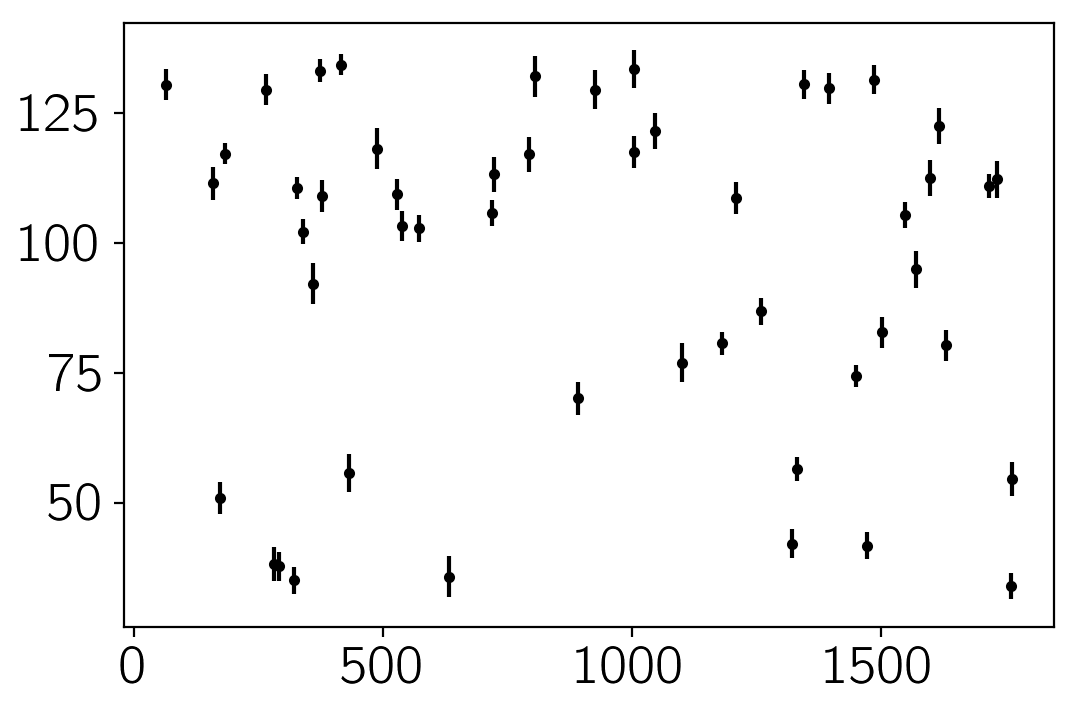

In [33]:
rv = rv_true + rv_err * np.random.randn(len(rv_err))
plt.errorbar(t, rv, yerr=rv_err, fmt=".k")

In [34]:
rv_tensor = tf.placeholder(T, (None,))
rv_err_tensor = tf.placeholder(T, (None,))

resid2 = tf.reduce_sum(tf.square((rv_tensor - model) / rv_err))

opt = tf.train.AdamOptimizer()
step = opt.minimize(resid2)

In [37]:
import tqdm

with tf.Session() as session:
    tf.global_variables_initializer().run()
    data = {t_tensor: t, rv_tensor: rv, rv_err_tensor: rv_err}
    print(session.run(resid2, feed_dict=data))
    
    inits = session.run(params)
    shapes = list(map(np.shape, inits))
        
    for i in tqdm.trange(1000):
        session.run(step, feed_dict=data)
#         print(session.run(resid2, feed_dict=data))
    print(session.run(resid2, feed_dict=data))

    param_vector = session.run(params)
    period_result = session.run(P)

  0%|          | 1/1000 [00:00<02:03,  8.08it/s]

46.5146531808


100%|██████████| 1000/1000 [00:00<00:00, 1297.71it/s]

40.3248183544


<Container object of 3 artists>

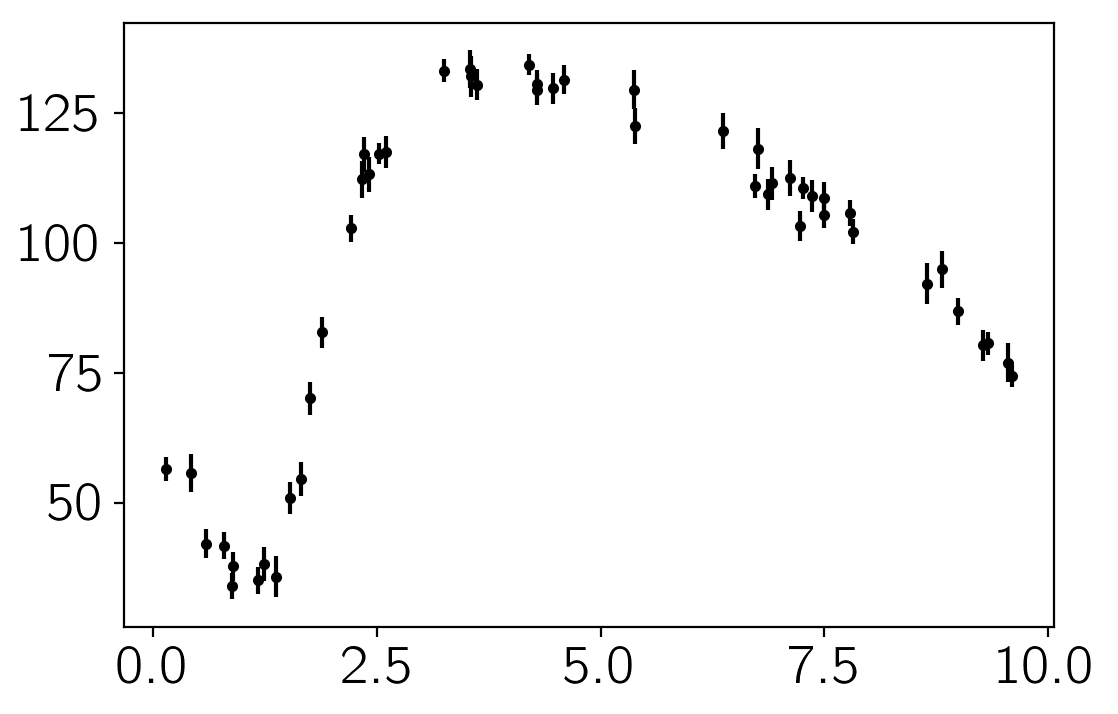

In [38]:
plt.errorbar(t % period_result, rv, yerr=rv_err, fmt=".k")